# Analysis across 50 world cities

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import planarity
import warnings
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from planar_analysis import *
from scipy import stats
from shapely import wkt
ox.config(use_cache=True, log_console=True)

In [2]:
df = pd.read_csv('data/results.csv', encoding='utf-8').drop('Unnamed: 0', axis=1)
df['geometry'] = df['geometry'].map(lambda x: wkt.loads(x))
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.crs = {'init': 'epsg:4326'}

In [3]:
gdf.head()

,city,count_cleaned_intersections,count_nonplanar_intersections,count_planar_intersections,country,distance,edge_length_ratio,geometry,is_planar,mean_edge_length,mean_planar_segment_length,network_type,nodes,overcount_nonplanar_cleaned,overcount_planar_cleaned,overcount_planar_nonplanar,phi,runtime
0,Buenos Aires,216,227,227,Argentina,805,1.000,POINT (-58.375547 -34.608657),True,108.411,108.411,drive,271,1.051,1.051,1.000,1.000,21.86
1,Buenos Aires,300,662,705,Argentina,805,0.941,POINT (-58.375547 -34.608657),False,55.254,51.981,walk,868,2.207,2.350,1.065,0.939,99.85
2,Sydney,149,175,240,Australia,805,0.735,POINT (151.208977 -33.863616),False,153.885,113.137,drive,221,1.174,1.611,1.371,0.729,16.55
3,Sydney,499,815,904,Australia,805,0.884,POINT (151.208977 -33.863616),False,53.720,47.469,walk,1028,1.633,1.812,1.109,0.902,137.04
4,Sao Paulo,288,330,428,Brazil,805,0.772,POINT (-46.6336 -23.549155),False,112.605,86.892,drive,416,1.146,1.486,1.297,0.771,33.75


In [4]:
# highest phi values
gdf[['city', 'phi']].sort_values(by='phi').head(10)

,city,phi
54,Moscow,0.540
84,Los Angeles,0.581
82,Dallas,0.584
86,Miami,0.641
15,Shanghai,0.660
70,Dubai,0.679
14,Shanghai,0.682
76,Atlanta,0.720
80,Cincinnati,0.723
94,Seattle,0.728


## map the results

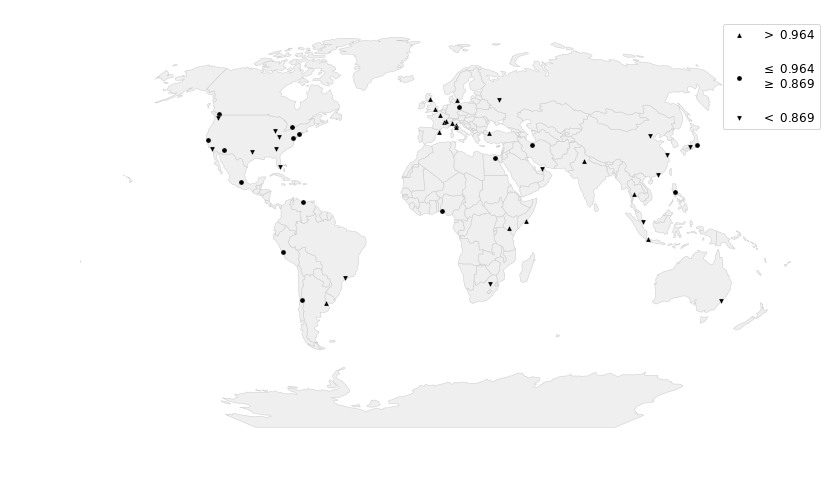

In [5]:
def get_marker(value, breaks):
    
    if value <= breaks[0]:
        return 1
    elif value <= breaks[1]:
        return 2
    else:
        return 3
    
drive = gdf[gdf['network_type']=='drive'].copy()
breaks = [drive['phi'].quantile(q=x) for x in (0.33, 0.67)]
drive['group'] = drive['phi'].apply(get_marker, breaks=breaks)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
crs_proj = '+proj=kav7'
world_proj = world.to_crs(crs_proj)
xmin, ymin, xmax, ymax = world_proj.unary_union.bounds
aspect_ratio = (xmax - xmin) / (ymax - ymin)
points_proj = drive.to_crs(crs_proj)

width = 14
fig, ax = plt.subplots(figsize=(width, width/aspect_ratio), facecolor='w')
ax = world_proj.plot(ax=ax, facecolor='#efefef', edgecolor='#cccccc', linewidth=0.5)

groups = []
points_proj[points_proj['group']==3].plot(ax=ax, marker='^', markersize=25, c='k', edgecolor='#cccccc', linewidth=0.3,
                                          label='$>$ {:.3f}'.format(breaks[1]))
points_proj[points_proj['group']==2].plot(ax=ax, marker='o', markersize=25, c='k', edgecolor='#cccccc', linewidth=0.3, 
                                          label='\n$\leq$ {:.3f}\n$\geq$ {:.3f}\n'.format(breaks[1], breaks[0]))
points_proj[points_proj['group']==1].plot(ax=ax, marker='v', markersize=25, c='k', edgecolor='#cccccc', linewidth=0.3, 
                                          label='$<$ {:.3f}'.format(breaks[0]))
    
plt.legend(prop={'size':12})

ax.axis('off')
fig.savefig('images/world_map_bw.svg', dpi=600)
plt.show()

## regression analysis

### first, untransformed linear model:

drive r^2=0.990, slope=0.905, intercept=0.094
walk r^2=0.993, slope=1.057, intercept=-0.061


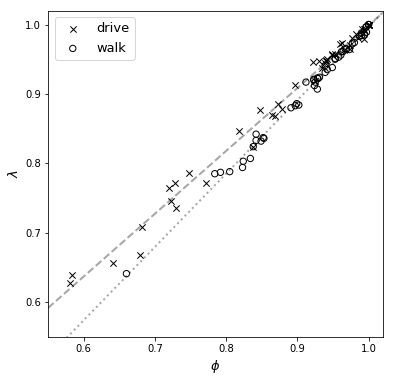

In [6]:
walk = gdf[gdf['network_type']=='walk']
drive = gdf[gdf['network_type']=='drive']
x = gdf['phi'].copy()
y = gdf['edge_length_ratio'].copy()
drive_x = drive['phi'].copy()
drive_y = drive['edge_length_ratio'].copy()
walk_x = walk['phi'].copy()
walk_y = walk['edge_length_ratio'].copy()

drive_slope, drive_intercept, drive_r_value, drive_p_value, drive_std_err = stats.linregress(drive_x, drive_y)
print('drive r^2={:.3f}, slope={:.3f}, intercept={:.3f}'.format(drive_r_value ** 2, drive_slope, drive_intercept))

walk_slope, walk_intercept, walk_r_value, walk_p_value, walk_std_err = stats.linregress(walk_x, walk_y)
print('walk r^2={:.3f}, slope={:.3f}, intercept={:.3f}'.format(walk_r_value ** 2, walk_slope, walk_intercept))

fig, ax = plt.subplots(figsize=(6,6))
drive_scatter = ax.scatter(x=drive_x, y=drive_y, c='k', edgecolor='none', s=40, linewidth=1, marker='x')
walk_scatter = ax.scatter(x=walk_x, y=walk_y, c='none', edgecolor='k', s=40, linewidth=1, marker='o')

# set x and y limits
x_min = 0.55
x_max = 1.02
y_min = 0.55
y_max = 1.02
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

# create a line of best fit
x_line = np.array([x_min, x_max])

drive_Y_est = x_line * drive_slope + drive_intercept
drive_line = ax.plot(x_line, drive_Y_est, c='k', alpha=0.35, linestyle='--', linewidth=2, zorder=-1)

walk_Y_est = x_line * walk_slope + walk_intercept
walk_line = ax.plot(x_line, walk_Y_est, c='k', alpha=0.35, linestyle=':', linewidth=2, zorder=-1)

fontsize = 13
fontname = 'DejaVu Sans'
ax.set_xlabel(r'$\phi$', fontsize=fontsize, fontname=fontname)
ax.set_ylabel(r'$\lambda$', fontsize=fontsize, fontname=fontname)
plt.legend([drive_scatter, walk_scatter], ['drive', 'walk'], prop={'size':fontsize, 'family':fontname})

fig.savefig('images/regression_lambda_phi_linear.svg', dpi=600)
plt.show()

## make latex table

In [7]:
cols = ['country', 'city', 'network_type', 'is_planar', 'phi', 'edge_length_ratio']
table = gdf[cols].reindex(cols, axis=1).set_index(['country', 'city', 'network_type']).unstack(level=2)
table = table.swaplevel(i=0, j=1, axis=1)
table.columns = ['_'.join(col).strip() for col in table.columns]
table = table.rename(columns={'drive_edge_length_ratio' : 'd_ELR', 'drive_is_planar' : 'd_planar',
                      'drive_phi' : 'd_phi',
                      'walk_edge_length_ratio' : 'w_ELR', 'walk_is_planar' : 'w_planar',
                      'walk_phi' : 'w_phi'})
table = table.reindex(['d_planar', 'd_phi', 'd_ELR', 'w_planar', 'w_phi', 'w_ELR'], axis=1)
table['d_planar'] = table['d_planar'].map(lambda x: 'Yes' if x else 'No')
table['w_planar'] = table['w_planar'].map(lambda x: 'Yes' if x else 'No')
table

d_planar  d_phi  d_ELR w_planar  w_phi  w_ELR
country      city                                                       
Argentina    Buenos Aires       Yes  1.000  1.000       No  0.939  0.941
Australia    Sydney              No  0.729  0.735       No  0.902  0.884
Brazil       Sao Paulo           No  0.771  0.772       No  0.824  0.803
Canada       Toronto            Yes  0.922  0.946       No  0.838  0.824
             Vancouver           No  0.930  0.948       No  0.923  0.920
Chile        Santiago            No  0.873  0.885       No  0.967  0.965
China        Beijing             No  0.818  0.846       No  0.842  0.842
             Hong Kong           No  0.838  0.823       No  0.823  0.794
             Shanghai            No  0.682  0.708       No  0.660  0.641
Denmark      Copenhagen         Yes  0.992  0.988       No  0.994  0.985
Egypt        Cairo               No  0.897  0.913       No  0.899  0.886
France       Lyon                No  0.995  0.991       No  0.958  0.953
             Paris               No  0.982  0.987       No  0.928  0.907
Germany      Berlin              No  0.939  0.945       No  0.939  0.931
India        Delhi              Yes  1.000  1.000      Yes  0.997  0.989
Indonesia    Jakarta            Yes  0.990  0.994       No  0.969  0.965
Iran         Tehran              No  0.962  0.973       No  0.953  0.951
Italy        Bologna            Yes  1.000  1.000      Yes  0.996  0.996
             Florence           Yes  0.993  0.994       No  0.980  0.974
             Milan              Yes  1.000  1.000       No  0.849  0.832
Japan        Osaka               No  0.868  0.868       No  0.953  0.950
             Tokyo               No  0.925  0.919       No  0.924  0.912
Kenya        Nairobi             No  0.974  0.971       No  0.949  0.938
Mexico       Mexico City         No  0.940  0.949       No  0.912  0.917
Nigeria      Lagos               No  0.960  0.972       No  0.990  0.988
Peru         Lima                No  0.941  0.951       No  0.923  0.921
Philippines  Manila              No  0.940  0.947       No  0.897  0.883
Russia       Moscow              No  0.540  0.596       No  0.842  0.833
Singapore    Singapore           No  0.864  0.869       No  0.891  0.880
Somalia      Mogadishu          Yes  1.000  1.000      Yes  1.000  1.000
South Africa Johannesburg        No  0.847  0.877       No  0.997  0.997
Spain        Barcelona          Yes  1.000  1.000       No  0.925  0.917
Switzerland  Geneva              No  0.985  0.981       No  0.834  0.807
Thailand     Bangkok             No  0.993  0.979       No  0.990  0.984
Turkey       Istanbul            No  0.965  0.964       No  0.973  0.964
UAE          Dubai               No  0.679  0.668       No  0.852  0.837
UK           Edinburgh           No  0.974  0.965       No  0.987  0.983
             London              No  0.976  0.980       No  0.853  0.836
USA          Atlanta             No  0.720  0.765       No  0.805  0.788
             Chicago             No  0.748  0.786       No  0.792  0.787
             Cincinnati          No  0.723  0.746       No  0.929  0.922
             Dallas              No  0.584  0.639      Yes  0.961  0.956
             Los Angeles         No  0.581  0.627       No  0.784  0.785
             Miami               No  0.641  0.657       No  0.962  0.961
             New York            No  0.879  0.878       No  0.928  0.923
             Phoenix             No  0.949  0.958       No  0.977  0.972
             San Francisco       No  0.935  0.937       No  0.942  0.935
             Seattle             No  0.728  0.771       No  0.931  0.924
             Washington DC       No  0.948  0.956       No  0.964  0.961
Venezuela    Caracas             No  0.953  0.957      Yes  1.000  1.000

In [8]:
print(table.to_latex())

\begin{tabular}{lllrrlrr}
\toprule
          &         & d\_planar &  d\_phi &  d\_ELR & w\_planar &  w\_phi &  w\_ELR \\
country & city &          &        &        &          &        &        \\
\midrule
Argentina & Buenos Aires &      Yes &  1.000 &  1.000 &       No &  0.939 &  0.941 \\
Australia & Sydney &       No &  0.729 &  0.735 &       No &  0.902 &  0.884 \\
Brazil & Sao Paulo &       No &  0.771 &  0.772 &       No &  0.824 &  0.803 \\
Canada & Toronto &      Yes &  0.922 &  0.946 &       No &  0.838 &  0.824 \\
          & Vancouver &       No &  0.930 &  0.948 &       No &  0.923 &  0.920 \\
Chile & Santiago &       No &  0.873 &  0.885 &       No &  0.967 &  0.965 \\
China & Beijing &       No &  0.818 &  0.846 &       No &  0.842 &  0.842 \\
          & Hong Kong &       No &  0.838 &  0.823 &       No &  0.823 &  0.794 \\
          & Shanghai &       No &  0.682 &  0.708 &       No &  0.660 &  0.641 \\
Denmark & Copenhagen &      Yes &  0.992 &  0.988 &       No &  0.

# More detailed summary statistics

In [9]:
walk = pd.read_csv('data/results_walk.csv')
drive = pd.read_csv('data/results_drive.csv')

In [10]:
walk.columns

Index(['country', 'city', 'distance', 'network_type',
       'count_cleaned_intersections', 'count_nonplanar_intersections',
       'count_planar_intersections', 'edge_length_ratio', 'geometry',
       'is_planar', 'mean_edge_length', 'mean_planar_segment_length', 'nodes',
       'overcount_nonplanar_cleaned', 'overcount_planar_cleaned',
       'overcount_planar_nonplanar', 'phi', 'runtime'],
      dtype='object')

In [11]:
print(drive['is_planar'].sum() / len(walk))
print(drive['phi'].mean())
print(drive['phi'].std())
print(drive['phi'].min())
print(drive['phi'].max())
print(drive['edge_length_ratio'].mean())
print(drive['edge_length_ratio'].std())
print(drive['edge_length_ratio'].min())
print(drive['edge_length_ratio'].max())
print((drive['phi']==1).sum())
print((drive['edge_length_ratio']==1).sum())

0.2
0.88146
0.12928645777213213
0.54
1.0
0.8916200000000001
0.11764645930819637
0.596
1.0
6
6


In [12]:
print(walk['is_planar'].sum() / len(walk))
print(walk['phi'].mean())
print(walk['phi'].std())
print(walk['phi'].min())
print(walk['phi'].max())
print(walk['edge_length_ratio'].mean())
print(walk['edge_length_ratio'].std())
print(walk['edge_length_ratio'].min())
print(walk['edge_length_ratio'].max())
print((walk['phi']==1).sum())
print((walk['edge_length_ratio']==1).sum())

0.1
0.91694
0.07177186362470508
0.66
1.0
0.90888
0.07614369873563313
0.6409999999999999
1.0
2
2


In [13]:
var = 'phi'
asc = True
drive.sort_values(var, ascending=asc)[['city', var]]

,city,phi
27,Moscow,0.540
42,Los Angeles,0.581
41,Dallas,0.584
43,Miami,0.641
35,Dubai,0.679
7,Shanghai,0.682
38,Atlanta,0.720
40,Cincinnati,0.723
47,Seattle,0.728
1,Sydney,0.729


In [14]:
drive[drive['is_planar'] == True].sort_values('phi')[['city', 'phi', 'edge_length_ratio']]

,city,phi,edge_length_ratio
3,Toronto,0.922,0.946
15,Jakarta,0.990,0.994
9,Copenhagen,0.992,0.988
18,Florence,0.993,0.994
0,Buenos Aires,1.000,1.000
14,Delhi,1.000,1.000
17,Bologna,1.000,1.000
19,Milan,1.000,1.000
29,Mogadishu,1.000,1.000
31,Barcelona,1.000,1.000


In [15]:
walk[walk['is_planar'] == True].sort_values('phi')[['city', 'phi', 'edge_length_ratio']]

,city,phi,edge_length_ratio
41,Dallas,0.961,0.956
17,Bologna,0.996,0.996
14,Delhi,0.997,0.989
29,Mogadishu,1.000,1.000
49,Caracas,1.000,1.000


In [16]:
drive['drive_walk_phi'] = (walk['phi'] / drive['phi'])
drive[['city', 'drive_walk_phi']].sort_values('drive_walk_phi')

,city,drive_walk_phi
32,Geneva,0.846701
19,Milan,0.849000
37,London,0.873975
3,Toronto,0.908894
31,Barcelona,0.925000
0,Buenos Aires,0.939000
12,Paris,0.945010
26,Manila,0.954255
11,Lyon,0.962814
7,Shanghai,0.967742


In [17]:
print(drive['overcount_planar_nonplanar'].mean())
print(1 - drive['edge_length_ratio'].mean())
print(walk['overcount_planar_nonplanar'].mean())
print(1 - walk['edge_length_ratio'].mean())

1.1646
0.10837999999999992
1.09806
0.09111999999999998


In [18]:
ns = 100
cs = 50

True


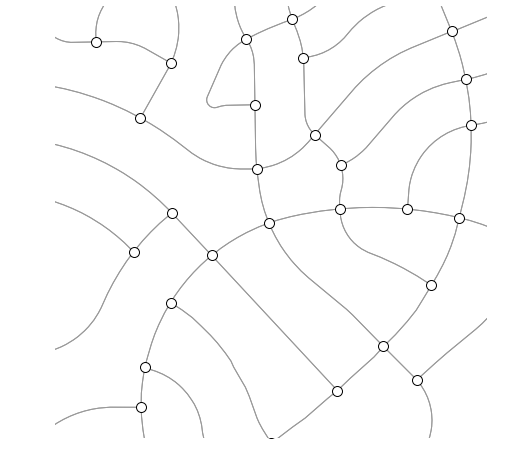

In [19]:
pt = (38.586683, -121.375365)
dist = 500

G = ox.graph_from_point(pt, network_type='drive', distance=dist*2, truncate_by_edge=True)
G = ox.project_graph(G)

warnings.filterwarnings(action='ignore')
print(planarity.is_planar(G))
warnings.filterwarnings(action='default')

bbox = ox.bbox_from_point(pt, dist, project_utm=True)
fig, ax = ox.plot_graph(G, bbox=bbox, fig_height=6, fig_width=6, 
                        node_size=ns, node_zorder=2, node_color='w', node_edgecolor='k',
                        save=True, filename='planar', file_format='svg', dpi=600, margin=0)

fig.savefig(fname='images/planar-{}-{}.png'.format(ns, cs), dpi=600)

False


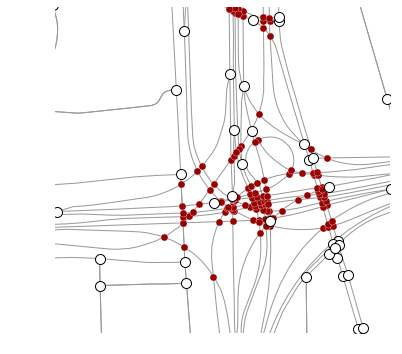

In [20]:
# define center point and bounding box
coords = (32.909035, -96.898432)
bbox = ox.bbox_from_point(coords, dist, project_utm=True)
north, south, east, west = bbox
poly = Polygon([(west, north), (west, south), (east, south), (east, north)])

# get a buffered graph
G = ox.graph_from_point(coords, network_type='drive', distance=dist*2, truncate_by_edge=True)
G = ox.project_graph(G)

# do planarity analysis so we can plot non-intersection line-crossings
planar_intersections = calculate_planar_intersections(G, poly)

# test formal planarity
warnings.filterwarnings(action='ignore')
print(planarity.is_planar(G))
warnings.filterwarnings(action='default')

# plot graph
fig, ax = ox.plot_graph(G, bbox=bbox, fig_height=6, fig_width=6, 
                        node_size=ns, node_zorder=3, node_color='w', node_edgecolor='k',
                        save=False, show=False, close=False, margin=0)

# scatter plot line crossings
x = planar_intersections.map(lambda pt: pt.x)
y = planar_intersections.map(lambda pt: pt.y)
ax.scatter(x, y, s=cs, c='#990000', edgecolors='w', linewidths=0.3, zorder=2)

fig.savefig(fname='images/nonplanar.svg', dpi=600)
fig.savefig(fname='images/nonplanar-{}-{}.png'.format(ns, cs), dpi=600)
plt.show()

# Single city analysis

In [21]:
df = pd.read_csv('data/city_samples.csv').drop('Unnamed: 0', axis=1)
df.head()

,coords,count_cleaned_intersections,count_nonplanar_intersections,count_planar_intersections,distance,edge_length_ratio,is_planar,mean_edge_length,mean_planar_segment_length,name,network_type,nodes,overcount_nonplanar_cleaned,overcount_planar_cleaned,overcount_planar_nonplanar,phi,runtime
0,"(37.81457038291894, -122.25529153926769)",205,251,291,805,0.883985,False,117.965467,104.279670,"00_Oakland, California, USA",drive,300,1.224390,1.419512,1.159363,0.862543,24.029637
1,"(37.80568383476944, -122.25476751037529)",170,201,205,805,0.981220,True,107.174370,105.161688,"01_Oakland, California, USA",drive,261,1.182353,1.205882,1.019900,0.980488,23.585007
2,"(37.807481931575765, -122.28028026741039)",231,290,366,805,0.831538,False,112.620406,93.648096,"02_Oakland, California, USA",drive,353,1.255411,1.584416,1.262069,0.792350,32.123001
3,"(37.80936423077242, -122.2137352007491)",141,157,157,805,1.000000,True,144.187262,144.187245,"04_Oakland, California, USA",drive,225,1.113475,1.113475,1.000000,1.000000,16.023003
4,"(37.737072168646584, -122.18838543235465)",139,159,177,805,0.922819,False,132.834136,122.581820,"05_Oakland, California, USA",drive,226,1.143885,1.273381,1.113208,0.898305,15.483002


In [22]:
df['overcount_planar_nonplanar'].mean()

1.0908427182636742

In [23]:
df['phi'] = 1 / df['overcount_planar_nonplanar']
cols = ['phi', 'edge_length_ratio']
df2 = df[cols].copy().head(100)
table = df2[cols].describe().round(3)
table = table.loc[['count', 'mean', 'std', 'min', 'max']]
table

,phi,edge_length_ratio
count,100.000,100.000
mean,0.929,0.939
std,0.103,0.089
min,0.569,0.567
max,1.000,1.000


In [24]:
print(table.to_latex())

\begin{tabular}{lrr}
\toprule
{} &      phi &  edge\_length\_ratio \\
\midrule
count &  100.000 &            100.000 \\
mean  &    0.929 &              0.939 \\
std   &    0.103 &              0.089 \\
min   &    0.569 &              0.567 \\
max   &    1.000 &              1.000 \\
\bottomrule
\end{tabular}



In [25]:
df.head(100)['is_planar'].value_counts()

True     67
False    33
Name: is_planar, dtype: int64

In [26]:
len(df.head(100)[df.head(100)['overcount_planar_nonplanar'] > 1])

63